In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.models.blei_lafferty_score import BleiLaffertyScore
from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config

from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset

%load_ext autoreload
%autoreload 2

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Get dataset

In [5]:
DATASET_PATH = "/home/sultan/datasets/PScience/PScience.csv"

In [6]:
dataset = Dataset(DATASET_PATH)
dictionary = dataset.get_dictionary()

In [7]:
print(dataset.get_possible_modalities())
dataset.get_dataset().head()

{'@2gramm', '@snippet', '@title', '@post_tag', '@author', '@3gramm', '@word'}


,vw_text,raw_text
id,,
1.txt,1.txt |@author fuchs preobrazhensky tabachniko...,@title Автограф # «Математический дивертисмент...
2.txt,2.txt |@word книга:2 лекция:3 рассматриваться:...,@title Главы: Маскулинности в российском конте...
3.txt,3.txt |@word развитие появляться пиджина:4 бел...,@title Пиджины и креольские языки | @snippet Л...
4.txt,4.txt |@word стандартный задача:3 состоять:4 р...,@title FAQ: Физиология микроводорослей | @snip...
5.txt,5.txt |@2gramm повседневный_практика государст...,@title Русская государственная идеология | @sn...


### Make initial model

In [8]:
with open("/home/sultan/recipes/ARTM_baseline.yml", "r") as f:
    yaml_string = f.read()

specific_topics = [f'topic_{i}' for i in range(30)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 1)]

yaml_string = yaml_string.format(
    modality_list=['@2gramm', '@word', '@post_tag', '@3gramm'],
    main_modality='@word',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string)

# This config follows a strategy described by Murat Apishev
# one of the core programmers of BigARTM library in personal correspondence.
# According to his letter 'decent' topic model can be obtained by
# Decorrelating model topics simultaneously looking at retrieved TopTokens


# Use .format(modality_list=modality_list, main_modality=main_modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, better left to the user to define optimal topic number
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29'] 
    background_topics: 

### Run experiment

In [9]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./MuratDemo') == True:
    os.system("rm -rf ./MuratDemo")
experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id="MuratDemo",
    save_path="MuratDemo"
)

In [10]:
experiment.run(dataset)

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning_message)


{<topicnet.cooking_machine.models.topic_model.TopicModel at 0x7fb3c42fba20>}

In [11]:
experiment.show()

Experiment MuratDemo

Experiment was made with BigARTM 0.9.0
Tree:
                                ┌##11h24m55s_13d11m2019y###
                                ├##11h25m46s_13d11m2019y###
                                ├##11h26m41s_13d11m2019y###
<<<<<<<<<<<root>>>>>>>>>>>──────┤
                                ├##11h27m36s_13d11m2019y###
                                ├##11h28m31s_13d11m2019y###
                                └##11h29m25s_13d11m2019y###
Cubes:
 START                          | REG_MODIFIER                                                                                         
                                | cube:                                                                                                
 name:                          |   <topicnet.cooking_machine.cubes.regularizer_cube.RegularizersModifierCube object at 0x7fb3c4190e10>
   ARTM                         |                                                                                           

In [12]:
best_model = experiment.select(experiment.criteria[-1][0])[0]

In [13]:
best_model.describe_regularizers()

tau  gamma
model_id                   regularizer_name                    
##11h28m31s_13d11m2019y### smooth_phi_bcg      19.899208    NaN
                           smooth_theta_bcg   187.195195    NaN
                           decorrelation_phi    0.030000    0.0

In [14]:
best_model.describe_scores()

last_value
model_id                   score_name                                                                               
##11h28m31s_13d11m2019y### PerplexityScore@all                                                           1.12113e+10
                           SparsityThetaScore                                                              0.0496475
                           SparsityPhiScore@2gramm                                                          0.647095
                           PerplexityScore@2gramm                                                            2025.87
                           TopicKernel@2gramm.average_coherence                                                    0
                           TopicKernel@2gramm.average_contrast                                              0.498668
                           TopicKernel@2gramm.average_purity                                                0.385329
                           TopicKernel@2gramm.average_size                                                   270.839
                           TopicKernel@2gramm.coherence            {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@2gramm.contrast             {'topic_0': 0.5064159035682678, 'topic_1': 0.4...
                           TopicKernel@2gramm.purity               {'topic_0': 0.4095296561717987, 'topic_1': 0.3...
                           TopicKernel@2gramm.size                 {'topic_0': 197.0, 'topic_1': 246.0, 'topic_2'...
                           TopicKernel@2gramm.tokens               {'topic_0': ['молекула_память', 'функция_мозг'...
                           SparsityPhiScore@word                                                            0.493199
                           PerplexityScore@word                                                                 3340
                           TopicKernel@word.average_coherence                                                      0
                           TopicKernel@word.average_contrast                                                0.465291
                           TopicKernel@word.average_purity                                                  0.137143
                           TopicKernel@word.average_size                                                     520.032
                           TopicKernel@word.coherence              {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@word.contrast               {'topic_0': 0.4519045948982239, 'topic_1': 0.4...
                           TopicKernel@word.purity                 {'topic_0': 0.11439121514558792, 'topic_1': 0....
                           TopicKernel@word.size                   {'topic_0': 121.0, 'topic_1': 159.0, 'topic_2'...
                           TopicKernel@word.tokens                 {'topic_0': ['неполадка', 'однократный', 'ради...
                           SparsityPhiScore@post_tag                                                        0.825876
                           PerplexityScore@post_tag                                                          50.1445
                           TopicKernel@post_tag.average_coherence                                                  0
                           TopicKernel@post_tag.average_contrast                                            0.764137
                           TopicKernel@post_tag.average_purity                                              0.824824
                           TopicKernel@post_tag.average_size                                                  34.129
                           TopicKernel@post_tag.coherence          {'topic_0': 0.0, 'topic_1': 0.0, 'topic_2': 0....
                           TopicKernel@post_tag.contrast           {'topic_0': 0.7715383172035217, 'topic_1': 0.7...
                           TopicKernel@post_tag.purity             {'topic_0': 0.8896540999412537, 'topic_1': 0.8...
           

## Results

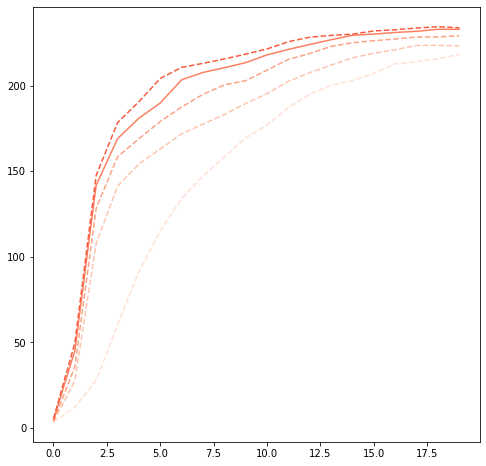

In [15]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['BleiLaffertyScore']
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
plt.show()

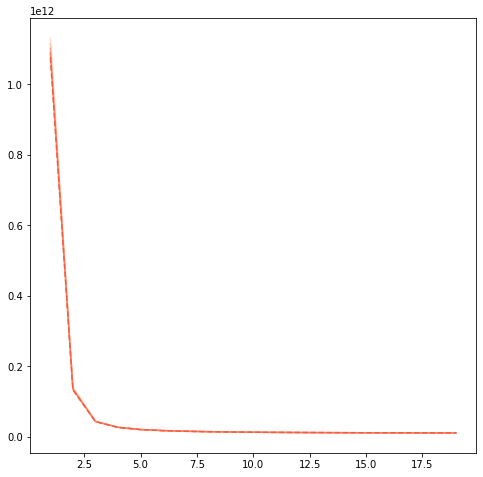

In [16]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    score[0] = float("nan")
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
plt.show()

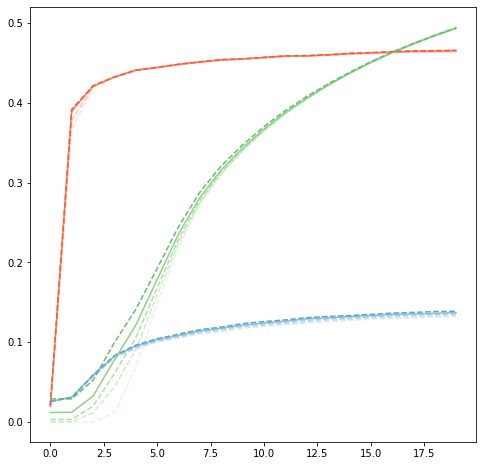

In [17]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]), ls=ls)
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
    
    score = tm.scores['SparsityPhiScore@word']
    plt.plot(score, color=cm.Greens(colors[i]), ls=ls)

plt.show()

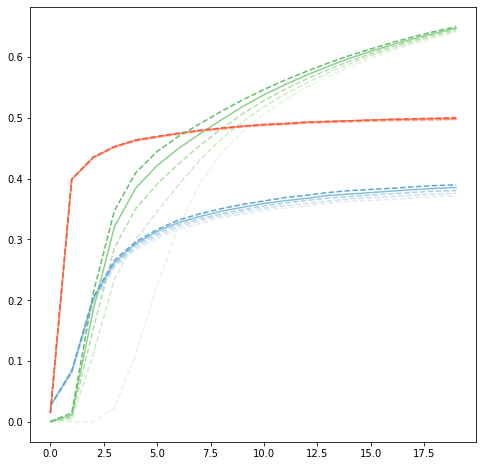

In [18]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    ls = "-" if tm.model_id == best_model.model_id else "--" 
    score = tm.scores['TopicKernel@2gramm.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]), ls=ls)
    score = tm.scores['TopicKernel@2gramm.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]), ls=ls)
    
    score = tm.scores['SparsityPhiScore@2gramm']
    plt.plot(score, color=cm.Greens(colors[i]), ls=ls)

plt.show()

## Investigate model

In [19]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer

In [20]:
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view())
first_model_top_doc = TopDocumentsViewer(best_model, dataset=dataset).view()

In [21]:
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw


n=None
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[:n]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_vw = dataset.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

,topic_0 @2gramm
нервный_клетка,0.03817
нервный_система,0.02548
человеческий_мозг,0.01042
потенциал_действие,0.00916
орган_чувство,0.00892
кратковременный_память,0.00871
структура_мозг,0.00809
долговременный_память,0.00807
область_мозг,0.00558
мышечный_волокно,0.00548


точка зрения # проблемы коммуникации ученых и сми мнения экспертов постнауки о том, с какими трудностями сталкиваются ученые при общении с представителями средств массовой информации

faqкомандные нейроны 5 фактов о различных функциях клеток в нервной системе

нейрогенетика памяти нейробиолог павел балабан о молекулах памяти, полногеномном анализе и нейродегенаративных заболеваниях

молекулярные механизмы памяти нейробиолог павел балабан о процессе обучения, «молекуле памяти» и высших функциях мозга

на восприятие пространства влияет геометрия окружения о зависимости структуры области возбуждения grid-нейронов от формы окружающего пространства

главы # белл и его «подрывное» открытие отрывок из книги "главный рубильник. расцвет и гибель информационных империй" профессора колумбийского университета тима ву

структура нервных клеток нейробиолог сергей саложин о синапсах, пути нейромедиатора и передаче информации в мозге

обнаружена уникальная звуковая система, позволяющая попугаям разговаривать ученые обнаружили структуры в мозге попугая, отвечающие за звукоподражание

командные нейроны нейробиолог павел балабан о сенсорных нейронах, исследованиях беспозвоночных и моделирующих клетках

главыкак работают мышцы отрывок из книги «искра жизниэлектричество в теле человека» профессора физиологии фрэнсис эшкрофт о роли ионных каналов в организме человека

,topic_1 @2gramm
нобелевский_премия,0.01936
кристаллический_структура,0.01214
высокий_давление,0.01023
химический_связь,0.00765
магнитный_поль,0.00747
новое_материал,0.007
высокий_температура,0.00694
волновой_функция,0.00685
химический_реакция,0.00649
новый_материал,0.00627


дизайн сверхтвердых материалов химик артем оганов о структуре алмаза, применении сверхтвердых материалов и новых формах углерода

методы предсказания кристаллических структур химик артем оганов о задачах кристаллографии, методе uspex и структуре алмаза

спиновые стекла физик михаил фейгельман о замерзших магнитных структурах, спиновых волнах и иерархии состояний

черный кремний профессор гарвардского университета эрик мазур о монооксиде углерода, грантовой системе, экспериментах с кремнием и серой и фотодетекторах

запрещенные химические соединения химик артем оганов о составе вещества на поверхности, возникновении новой химии и химических реакциях в экстремальных условиях

5 книг о теоретическом материаловедении что читать о движении атомов в кристаллах, молекулярной динамике и структуре твердых материалов, рекомендует phd in crystallography артем оганов

faqмногомерные массивы 6 фактов о методах и перспективах решения многомерных задач в вычислительной химии и физике твердого тела

премии # нобелевская премия мира - 2013 спецпроект постнауки, посвященный нобелевской неделе и её результатам

фуллерены нобелевский лауреат по химии харольд крото о молекулярных решетках, исследовании углеродных звезд и фундаментальной науке

водородная связь и жидкости на земле физик вадим бражкин о межатомном взаимодействии, природе химической связи и важности углерода

,topic_2 @2gramm
греческий_миф,0.00792
греческий_мифология,0.00696
vi_век,0.00604
культурный_ландшафт,0.00537
культурный_традиция,0.00534
снорри_стурлусон,0.00527
история_искусство,0.00498
центральный_мексика,0.00481
скальдический_стих,0.00407
viii_век,0.00405


ацтекская империя историк дмитрий беляев о тройственном союзе ацтеков, формировании империи в теночтитлане и военно-религиозной идеологии

автограф # «мода и люди. новая теория моды и модного поведения» беседа с социологом моды александром гофманом о его книге, посвященной этому сложному феномену

первая империя мезоамерики историк дмитрий беляев об организации пространства теотиуакана, городском быте и особенностях культурной экспансии

государства сапотеков и миштеков историк дмитрий беляев о культе предков, стенах черепов и археологических исследованиях в долине оахаки

миф и архитектура филолог гасан гусейнов о мифологическом измерении архитектуры, ахиллесовой пяте и изоморфизме строений и человеческого тела

faqэрос в античной культуре 7 фактов об одном из самых загадочных персонажей греческой мифологии

автограф«люди, тексты и вещи. из истории культуры средневековой скандинавии» филолог федор успенский о семи столпах скандинавской культуры, снорри стурлусоне и уникальности поэзии скальдов

5 книг по истории доколумбовой америки что читать об индейских культурах нового cвета, рекомендует кандидат исторических наук дмитрий беляев

кризис мезоамериканских государств классического периода историк дмитрий беляев о процессе балканизации, упадке теотиуакана и самом масштабном батальном памятнике в истории

главысвященное и секулярное отрывок из книги «от ритуала к рекорду» доктора американистики аллена гуттмана о спорте как прообразе новой светской религии

,topic_3 @2gramm
римский_право,0.02265
мировой_война,0.01247
право_собственность,0.01198
веймарский_республика,0.00928
европейский_союз,0.00855
католический_церковь,0.00822
правовой_система,0.00623
римский_юрист,0.00592
третье_сословие,0.00543
вещный_право,0.005


папство и россияистория дипломатических отношений как развивались отношения москвы и святого престола и с какими проблемами им приходилось сталкиваться?

левый терроризм в германии историк илья женин о студенческих протестах 1968 года, «фракции красной армии» и трагических событиях «немецкой осени»

5 книг по истории германии в хх веке что читать об историческом развитии германии от веймарской республики до современности, рекомендует кандидат исторических наук илья женин

правовые последствия смешения вещей юрист денис новак о смешении однородных вещей, праве собственности на такое имущество и кондикционном иске

веймарская республика историк илья женин о республике без республиканцев, октябрьской революции и социал-демократической партии

кондикция владения юрист денис новак о защите при неправомерном лишении владения, виндикационном и кондикционном исках и ценности владения имуществом

неисполнение и ответственность юрист дмитрий дождев об обязательствах должника, невозможности исполнения и положительном нарушении договора

«национал-социализм сыграл роковую роль в воспитании немецкого духа» интервью с историком ильей жениным о веймарской республике, советско-германских отношениях и немецком коллективизме

начало французской революции историк дмитрий бовыкин о движении санкюлотов, конституции 1791 года и псевдонаучных открытиях жан-поля марата

фидуциарные отношения юрист дмитрий дождев о привилегиях кредитора, англо-американском трасте и фидуции в германском праве

,topic_4 @2gramm
индоевропейский_язык,0.01217
языковой_семья,0.01101
человеческий_язык,0.01016
устный_речь,0.00881
естественный_язык,0.00764
разный_язык,0.00723
языковой_разнообразие,0.00661
исторический_языкознание,0.00641
носитель_язык,0.00637
русский_язык,0.00626


главы # в поисках родины отрывок из книги «генетическая одиссея человека» антрополога и популяционного генетика спенсера уэллса

машинный перевод на основе правил лингвист леонид иомдин о контроле смысла переведенного текста, интегральном описании языка и синтаксической неоднозначности

тело в русском языке и культуре лингвист григорий крейдлин о семиотической концептуализации тела, глубине членимости и свойствах телесных объектов

как взаимодействуют язык бытовой и язык официальный? лингвист борис иомдин об активном словарном запасе, языковых изменениях и текстах официальных документов

faqмультимодальная лингвистика 6 фактов о невербальной коммуникации, процессе понимания речи и будущем лингвистики

5 книг о сравнительно-историческом языкознании что читать о методах и различных теориях компаративной лингвистики, рекомендует кандидат филологических наук георгий старостин

faqметоды полевой лингвистики 7 фактов о способах работы с информантами

faqязык в интернете 6 фактов о трансформациях, произошедших с языком под влиянием новых средств коммуникаций

faqлингвистический анализ рассказов 6 фактов относительно структуры рассказа, компетенций рассказчика и дискурсивного жанра

faqоткрытие новых языков 7 фактов о работе лингвистов, корпусе текстов и качественных информантах

,topic_5 @2gramm
советский_союз,0.02028
мировой_война,0.02016
гражданский_война,0.01509
политический_философия,0.01176
политика_память,0.00966
советский_власть,0.00699
красный_армия,0.0062
начало_война,0.00553
российский_империя,0.0051
политический_режим,0.00493


главыинтерпретации сталинградской битвы отрывок из книги «сталинградская битвасвидетельства участников и очевидцев», вышедшей под редакцией историка йохена хелльбека

главысталин на войне отрывок из книги «сталин. жизнь одного вождя» историка олега хлевнюка о роли сталина в поражениях и победах в великой отечественной войне

культурная память о первой мировой историк борис колоницкий об источниках информации о первой мировой войне, политике памяти европейских стран и травме гражданской войны

«первая мировая война потеряна, у нас нет ее в памяти» интервью с историком алексеем миллером о политике памяти, войне 1812 года и значении «георгиевской ленточки»

эпоха сталина 11 материалов историка олега хлевнюка о зарождении и гибели сталинской эпохи, проблемах ее интерпретации и значении для мировой истории

приход сталина к власти историк олег хлевнюк о системе коллективного руководства после смерти ленина, заявлении сталина об отставке и полном контроле над органами госбезопасности

«сталин, коба и сосо. молодой сталин в исторических источниках» историк ольга эдельман о дореволюционной биографии сталина, проблеме верификации источников и задачах исторического исследования

патриотическая риторика в годы гражданской войны историк людмила новикова об антибольшевистском лагере, красной пропаганде и мифе об интервенции

практики построения личности в утопических сообществах как педагогические технологии влияли на жизнь советских детей и подростков

автограф«актуальное прошлое» политолог ольга малинова об интерпретациях исторических событий, концепции тысячелетней истории россии и важности дня победы для современной политики памяти

,topic_6 @2gramm
нитрид_бора,0.01453
поведение_животное,0.0093
юрский_период,0.00862
южный_америка,0.0082
живой_организм,0.00588
северный_америка,0.00576
частное_сектор,0.0046
южный_африка,0.00431
социальный_поведение,0.0043
ископаемое_растение,0.00403


прямая речьжанна резникова этолог, доктор биологических наук о поведении животных, их когнитивных способностях, этике и гражданской позиции ученых

5 книг об этологии что читать о различных аспектах поведения человека и животных, рекомендует доктор биологических наук дмитрий жуков

«многие юрские животные продолжили свое развитие и даже имеют потомков в наше время» палеонтолог чжунхэ чжоу о многообразии удивительных животных юрского периода

зависит ли коммуникация псовых от цвета их глаз? о социальном поведении собак и волков, их общении с помощью взгляда и охотничьих навыках

прямая речьфуад алескеров математик, руководитель департамента математики факультета экономики вшэ о проблемах российского образования, предсказаниях биржи и качествах ученого

faqсоциальное поведение свободноживущих лошадей 5 фактов о различных группах одичавших лошадей и их поведении

faqтеория речевых актов 5 фактов об аналитической теории речепорождения и понимании произведений художественной литературы

главы # если бога нет отрывок из книги «истоки моралив поисках человеческого у приматов» известного биолога франса де вааля

найдено древнейшее свидетельство внутреннего оплодотворения среди позвоночных о разнообразии групп рыб, копулятивных органах и издержках выхода на сушу

особенности строения голосеменных класса войновскиевых о спорных вопросах в изучении одной из самых своеобразных групп голосеменных растений, произраставших на земле в конце палеозойской эры

,topic_7 @2gramm
квантовый_компьютер,0.01483
длина_волна,0.01071
квантовый_точка,0.0079
квантовый_технология,0.00758
магнитный_поль,0.00687
квантовый_механика,0.00587
квантовый_состояние,0.0057
ядерный_энергетика,0.00566
магнитный_момент,0.00534
магнитный_пол,0.00486


faqядерный магнитный резонанс 5 фактов о природе магнитных полей, спектре ядерного магнитного резонанса и применении метода ямр в современной химии

что придет на смену кремниевой электронике? физик алексей орлов о проблеме тепловыделения, попытках найти альтернативы кремнию и клеточных автоматах на квантовых точках

faqквантовые интерфейсы 7 фактов об устройствах, позволяющих соединять два разных квантовых объекта друг с другом

эффект переноса спина в спинтронике физик константин звездин о технологических проблемах наноэлектроники, магнитном вихре и генераторе свч-излучения

«квантовая телепортация используется для передачи секретной информации, которую невозможно украсть» интервью с физиком юджином ползиком о современном понимании идеи телепортации, сериале «star trek» и принципах квантовой криптографии

faqтехнологии производства биотоплива микробиолог зоригто намсараев о биотопливной индустрии и факторах, которые определяют прибыльность того или иного сырья

faqатомная энергетика сегодня 7 фактов о перспективах развития атомной промышленности в современном мире

плащ-невидимкакак создают материалы, которые «обманывают» свет? о наноантеннах, оптических свойствах новых материалов, «гарри поттере» и перспективах нанофотоники

квантовая криптография выдержит ли классическая криптография появление квантового компьютера, существует ли абсолютно безопасное шифрование и как работают квантовые хакеры

солнечная энергетика физик евгений кац о преобразовании света в электричество, солнечном топливе и кпд современных аккумуляторов

,topic_8 @2gramm
стволовой_клетка,0.03257
естественный_отбор,0.02055
половый_отбор,0.0111
эволюционный_биология,0.00907
homo_sapiens,0.00877
теория_эволюция,0.00632
ход_эволюция,0.00557
процесс_эволюция,0.00557
костный_мозг,0.0055
человекообразный_обезьяна,0.0049


faqэмбриональные стволовые клетки 7 фактов об уникальном типе плюрипотентных клеток млекопитающих

faqнеандертальцы алтая 7 фактов о происхождении неандертальского населения на алтае, денисовой пещере и современных археологических исследованиях

эпигенетика и клонирование биолог рудольф йениш об овце долли, терапевтическом клонировании у млекопитающих и перепрограммировании клеток

как пациенту пересадили сетчатку глаза из «искусственных» клеток? о получении индуцированных плюрипотентных стволовых клеток и их применении в медицине

новые технологии в лечении болезней зрения биолог сергей киселев об амаврозе лебера, возрастных заболеваниях глаз и трансплантации эмбриональных стволовых клеток

главыобезьяночеловек отрывок из книги «рассказ предка» биолога ричарда докинза об истоках эволюционного древа и общих предках всех живых организмов

press-лекция # как сделать из одной клетки другуюхроники трансформаций генетик мария шутова о выращивании органов, культивировании ранних эмбриональных клеток и о биомедицинском применении их искусственных аналогов

биоинженерия стволовых клеток биоинженер али хадемхосейни об искусственной клеточной среде, образовании опухолей и инженерных подходах к исследованиям стволовых клеток

«социальная моногамия совершенно не коррелирует с сексуальной моногамией» интервью с биологом андреем чабовским о феномене моногамии, теории конфликта полов и причинах привязанности между партнерами

faqвозникновение человека 7 фактов о человекообразных обезьянах и эволюции человека

,topic_9 @2gramm
стандартный_модель,0.0319
элементарный_частица,0.03059
бозон_хиггс,0.02492
хиггсовский_бозон,0.01147
магнитный_пол,0.01072
электрический_заряд,0.01069
высокий_энергия,0.01025
сильный_взаимодействие,0.01023
космический_луч,0.00933
слабый_взаимодействие,0.00896


спонтанное нарушение симметрии физик дмитрий казаков о массах частиц, слабых взаимодействиях и теореме голдстоуна

симметрии в мире элементарных частиц физик дмитрий казаков о типах преобразований в физике частиц, лоренц-инвариантности и нарушениях симметрии

faqтоп-кварк 7 фактов о наиболее массивной частице стандартной модели

антиоксиданты и сердечно-сосудистые заболевания фармаколог олег медведев о компонентах антиоксидантной системы, формах коэнзима и новых свойствах водорода

адроны физик дмитрий казаков о мире мезонов и барионов, свойствах кварков и адронных резонансах

faqcp-нарушение в кварках 7 фактов о смешивании поколений кварков, экспериментах на бак и асимметрии в мире элементарных частиц

линейный коллайдер физик михаил данилов о недостатках стандартной модели, изучении t-кварка и поиске новых измерений

элементарные частицы физик дмитрий казаков об истории открытия, свойствах и классификации элементарных частиц

стандартная модель физик михаил данилов об экспериментах на коллайдерах, массе фундаментальных частиц и суперсимметрии

детекторы для экспериментов на коллайдерах физик павел пахлов о взаимодействии элементарных частиц, устройстве детекторов и применении данной технологии в повседневной жизни

,topic_10 @2gramm
солнечный_система,0.03545
планетный_система,0.01154
космический_аппарат,0.00901
протопланетный_диск,0.009
король_артур,0.00891
иммунный_система,0.00866
извержение_вулкан,0.00745
теория_фрейм,0.00687
образование_планета,0.00673
социология_повседневность,0.00623


есть ли жизнь на других планетах? астроном владимир сурдин о возможном расселении людей на луне, искусственных городах и внеземных цивилизациях

faqприрода вулканов физик олег мельников о самых крупных извержениях в истории земли, доисторических потоках пепла от вулканов и видах проявлений вулканизма

социальные исследования иммунологии социолог денис сивков о различении между своим и чужим, исследованиях донны харауэй и моделях работы иммунной системы

faqобразование планетных систем 7 фактов о формировании скоплений звезд и различных незвёздообразных астрономических объектов

главыгорячее дыхание земли отрывок из книги «земля. метеориты, вулканы, землетрясения» геолога николая короновского о внутреннем строении земли и наиболее опасных геологических явлениях

формирование планет и протопланетные диски астрофизик сергей попов об образовании планетных систем, снеговой линии и облаке оорта

образование планетных систем астроном дмитрий вибе о каменных планетах и планетах-гигантах, многообразии планетных систем и горячих юпитерах

faqреспубликанизм и свобода 6 фактов о кабинетной попытке придумать новую идеологию в рамках аналитической философии политики

удивительный марс астроном владимир сурдин о "зоне жизни", магнитном поле марса и марсоходе curiosity

faqидеи декабристов 7 фактов о взглядах декабристов на переустройство страны

,topic_11 @2gramm
массовый_культура,0.02766
культовый_кино,0.01128
cinema_studies,0.01048
общество_потребление,0.00903
гуманитарный_наука,0.00793
французский_революция,0.00688
молодёжный_субкультура,0.00643
плохой_кино,0.00605
речь_идти,0.0054
хороший_вкус,0.00524


штурмуя публичное пространствослова о гетеротопии плохого вкуса философ александр павлов о теории кэмпа сьюзен сонтаг, русской традиции кинокритики и утопии хорошего вкуса

гендерные исследования в cinema studies философ александр павлов о методах психоанализа в cinema studies, образе «последней девушки» и анализе кинематографа с позиций феминизма

главы # скрытые механизмы идеологии в "бойцовском клубе" отрывок из книги «постыдное удовольствиефилософские и социально-политические интерпретации массового кинематографа» философа александра павлова

cinema studies как дисциплина философ и культуролог александр павлов об исследованиях кинематографа на западе, главных теоретиках cinema studies и развитии этой дисциплины в россии

5 книг о культовом кинематографе что читать о культовом кино, рекомендует доцент философского факультета ниу вшэ александр павлов

феномен happy end культуролог екатерина лапина-кратасюк о популярном кинематографе, фильмах жанра нуар и «кошмаре на улице вязов»

cinema studies 8 лекций философа и культуролога александра павлова о современных подходах к исследованию кинематографа

трансформации локальной культуры философ владимир миронов о глобальном коммуникационном пространстве, противостоянии высокой и массовой культуры и оппозиции «свой — чужой»

5 книг об анализе фильма что читать об исследованиях кинематографа на примере анализа конкретных фильмов, рекомендует философ александр павлов

«нет больше высокой и низкой культуры, есть просто культура сегодня» интервью с философом и культурологом александром павловым о философии массовой культуры, славое жижеке и обществе потребления

,topic_12 @2gramm
христианский_восток,0.01191
северный_кавказ,0.01078
ближний_восток,0.01004
национальный_государство,0.00959
саудовский_аравия,0.00644
головной_мозг,0.00639
арабский_весна,0.00556
vii_век,0.00554
христианский_культура,0.00552
арамейский_язык,0.00545


главыновые войны и политика отрывок из книги «новые и старые войны» политолога мэри калдор о новом типе организованного насилия

культура арабов-христиан до ислама историк алексей муравьёв об арабских племенах сирии и месопотамии, доисламском христианстве в южной аравии и трудностях изучения этих культур

функция счета и технический прогресс психолог александр тхостов о высших психических функциях, объеме памяти и утрате навыков устного счета

китайская эротология и врачевание востоковед алексей маслов о китайских медитативных практиках, древнем трактате о сексологии и разделении на женское и мужское начало

faq«братья-мусульмане» 6 фактов об особенностях организации «братьев-мусульман», причинах их популярности и политических перспективах

главы # студенческие коммуны отрывок из книги «в кругу сверстников» историка и специалиста по истории повседневности александра рожкова о буднях студенческих коммун в ссср 1920-х годов

христианская культура кавказской албании историк алексей муравьёв о народах кавказской албании, армянском влиянии на местную традицию христианства и удинском языке

5 мифов об алкоголе эксперты постнауки развенчивают мифы о вреде и пользе спиртных напитков

главы # пространство. социальный продукт и потребительная стоимость отрывок из книги «state, space, world. selected essays» французского философа и социолога анри лефевра

главы # город и глобализация отрывок из книги "город в теорииопыт осмысления пространства" доктора философских наук елены трубиной

,topic_13 @2gramm
чёрный_дыра,0.07313
нейтронный_звезда,0.0462
белый_карлик,0.01015
белых_карлик,0.01
компактный_объект,0.00849
звёздный_скопление,0.00805
зона_обитаемость,0.00735
спиральный_галактика,0.0069
млечный_путь,0.00674
химический_состав,0.00651


черные дыры в центрах галактик астрофизик ольга сильченко об открытии сверхмассивной черной дыры в туманности андромеды, исследованиях джона корменди и темных гравитирующих телах

главы # как все начиналось отрывок из книги «двигатели гравитации. как черные дыры управляют галактиками, звездами и жизнью в космосе» директора астробиологической обсерватории при колумбийском университете в нью-йорке kалеба шарфа

как были открыты черные дыры промежуточной массы? о методах определения массы черной дыры и загадке ультрамощных рентгеновских источников

ударные волны вблизи компактных объектов астрофизик валерий сулейманов о нейтронных звездах, гравитации на космических кораблях и ньютоновском пределе

галактический «каннибализм» астроном алексей расторгуев об испарении звезд, измерении массы млечного пути и слиянии галактик

обнаружена самая яркая нейтронная звезда о пределе эддингтона, ультраярких рентгеновских источниках и тесных двойных системах

рентгеновское небо в фокусе астрофизик михаил ревнивцев о рентгеновских телескопах, болометрах и проекте обсерватории «спектр-рентген-гамма»

черные дыры физик эмиль ахмедов об изучении черных дыр, карле шварцшильде и гигантских черных дырах

атмосферы экзопланет астрофизик сергей попов о способах изучения атмосферы, структуре внешних слоев газовой оболочки планет и горячих юпитерах

faqшаровые скопления 7 фактов об огромных и древних звёздных городах

,topic_14 @2gramm
промышленный_революция,0.01488
центральный_банк,0.01472
экономический_рост,0.01268
государственный_долг,0.00981
центральный_банка,0.00923
развивающийся_страна,0.00905
мировой_экономика,0.00866
развитый_страна,0.0076
финансовый_рынок,0.00724
заработный_плата,0.00704


главы # распределенный капитализм отрывок из книги «третья промышленная революция» экономиста и эколога джереми рифкина

экономические колебания экономист сергей афонцев о причинах роста и спада экономики, экономическом кризисе и несостоятельности теорий экономических циклов

главы # жиры и внимание к онкологическим заболеваниям отрывок из книг "китайское исследование" профессора биохимии колина кэмпбелла

faqоткрытие древних статуэток кавказа 5 фактов об исследованиях бронзовой антропоморфной пластики казбекского клада

faqсвятилища кавказа 7 фактов о сакральных местах кавказа языческого периода, об их археологическом исследовании и связи с христианскими церквями

главы # антропоморфная пластика, происходящая из святилищ кавказа отрывок из книги "древняя бронзовая антропоморфная пластика кавказа" историка ольги брилевой

faqнеформальность на рынке труда 6 фактов об интенсификации миграции и проблеме сопоставления заработков между разными секторами труда

великая депрессия историк юрий рогулёв об антикризисных мерах рузвельта, зарождении социального законодательства в сша и спаде американской экономики в 1930-х годах

главы # дефицит демократии отрывок из книги «по ту сторону невидимой рукиоснования новой экономической науки» старшего экономиста всемирного банка каушика басу

главыработа и безработица отрывок из книги "как работает экономика" экономиста ха-джун чанга о роли работы и безработицы в глобальном мире

,topic_15 @2gramm
психический_заболевание,0.00747
зеркальный_нейрон,0.00568
работа_мозг,0.00537
головной_мозг,0.00521
социальный_роль,0.00494
психический_расстройство,0.00471
депрессивный_состояние,0.00451
удар_ток,0.00412
философия_сознание,0.00369
кругосветный_путешествие,0.00354


механизмы самоутверждения личности психолог наталья харламенкова о трех стратегиях самоутверждения, типах личности и умении говорить «нет»

faqпсихическая травма и картина мира 5 фактов о последствиях травматических событий

faqпосттравматический стресс в отношениях «мать — дочь» 5 фактов о поведении матерей, переживших стрессовое событие

экспериментальная генетика поведения биолог инга полетаева о модельных животных, искусственном отборе и селекционных экспериментах

социологическая операционализация социолог виктор вахштайн о переводе концептов в операнты, смещении релевантности и теории рационального выбора

принцип «намеренной небрежности» в дендизме филолог ольга вайнштейн о впечатлении спонтанности в облике денди, поведении джентльменов в обществе и приеме table talk

эмоции в музыкевосприятие расстояний в тональном поле нейропсихолог марина корсакова-крейн о квинтовом круге, улавливании расстояний в тональном пространстве и важности интуиции в восприятии музыки

5 книг о натуралистах что читать о путешествиях исследователей дикой природы, рекомендует кандидат биологических наук сергей майоров

главы # клинический язык винникотта отрывок профессора психологии джаны абрам из четвертого «международного психоаналитического ежегодника» об инновациях в клинической психологии

«в эволюции живого не было “допсихического”, “чисто физиологического” этапа» интервью с психофизиологом юрием александровым о наличии и отсутствии сознания, свободе воли и различных способах решения психофизиологической проблемы

,topic_16 @2gramm
гравитационный_волна,0.02178
реликтовый_излучение,0.01869
теория_струна,0.01821
тёмный_энергия,0.01553
ранний_вселенная,0.01425
расширение_вселенная,0.01138
скопление_галактика,0.01035
тёмный_материя,0.00964
космологический_постоянный,0.00918
теория_гравитация,0.00895


поляризация реликтового излучения физик дмитрий горбунов об эксперименте bicep2, стадии инфляции и развитии теории гравитации

реликтовые гравитационные волны в свете данных обсерватории planck о b-моде поляризации реликтового излучения, намагниченной пыли и экспериментах bicep2 и planck

faqполяризация реликтового излучения 7 фактов о видах поляризации, эксперименте planck и доказательствах инфляционной стадии расширения вселенной

главысовременная космология отрывок из 3-го издания книги «астрономиявек xxi» под редакцией владимира сурдина о важнейших событиях и нерешенных проблемах астрономии

что изменит открытие первичных гравитационных волн? астрофизик сергей попов о теории инфляции, поиске первичных гравитационных волн и заявлении коллаборации bicep

faqвселенная до горячей стадии 5 фактов о теориях развития вселенной, инфляционной модели и гравитационных волнах

стандартная космологическая модель астрофизик олег верходанов об угловом спектре мощности, холодной темной материи и измерении космологических параметров

точная космология физик макс тегмарк о флуктуациях в ранней вселенной, темной энергии и теории инфляции

вселенная до горячей стадии физик валерий рубаков о реликтовом излучении, зарождении неоднородностей и гравитационных волнах

олег верходанов"самое точное знание о физике вселенной несет реликтовое излучение" интервью с астрофизиком о методах исследования вселенной, проблемах проведения измерений и стандартной космологической модели

,topic_17 @2gramm
принятие_решение,0.02657
теория_игра,0.01462
система_отсчёт,0.01082
принимать_решение,0.00786
поведенческий_экономика,0.00669
уравнение_максвелл,0.00526
преобразование_лоренц,0.00514
быстрый_сон,0.00511
когнитивный_наука,0.00487
когнитивный_исследование,0.00467


главыбедность и ребенок до появления на свет отрывок из книги «бедность и развитие ребенка» о том, как социальное неблагополучие влияет на разные аспекты развития ребенка

понятие поведенческой экономики экономист ксения паниди об идее рациональности, влиянии эмоций на поведение и когнитивных причинах экономических решений

главыискаженная демократия отрывок из книги «искаженная демократия» политолога нади урбинати об индивидуальной свободе, открытости политической игры и демократической легитимности

василий ключарев«особенности нашего экономического поведения можно объяснить дизайном мозга» о мозговых механизмах процесса принятия решения и влиянии рекламы на выбор покупателя

субботний интенсив «общая и специальная теория относительности» 2 апреля с 12:00 до 19:00 в академии постнауки

главыот механики ньютона до электродинамики максвелла отрывок из книги «гравитация» физика александра петрова о понимании места механики и электродинамики в общей физической картине мира на рубеже xix и xx веков

экономика соблазна экономист ксения паниди о теории перспектив, иллюзии невозвратных потерь и поведении людей в ситуации неопределенности

faqдизайн экономических механизмов 7 фактов о поиске взаимно-оптимальных стратегий при решении экономических игр

«мы не замечаем, сколь многого мы не замечаем» интервью с психологом марией фаликман о когнитивных науках, великой иллюзии сознания и кратковременной памяти

гендерные особенности инсомнии сомнолог михаил полуэктов о различиях инсомнии мужчин и женщин, социальных рисках бессонницы и проявлениях сонных расстройств при неврозах

,topic_18 @2gramm
русский_язык,0.06625
литературный_язык,0.01105
дискурсивный_слово,0.01034
английский_язык,0.00875
древний_русь,0.00824
христианский_имя,0.0073
русский_князь,0.00703
древнерусский_язык,0.0066
германский_язык,0.00659
множественный_число,0.00617


«глагольный вид является едва ли не самым сложным для изучения» интервью с лингвистом алексеем шмелевым о предмете изучения аспектологии, ошибках в употреблении глаголов и сложностях русской грамматики

русский диалектный консонантизм лингвист игорь исаев о твердости/мягкости согласных, особенностях артикуляции в говорах и методах фонетического анализа речи

двувидовые глаголы лингвист александр пиперски об особенностях глаголов совершенного и несовершенного вида, интеграции в русский язык заимствованных глаголов и видовых противоречиях в русских словарях

гласные русского языка лингвист игорь исаев об истории гласных в литературном языке, следах утраченных букв и особенностях говоров

faqударение на предлог 7 фактов о системе ударений и памяти языка в поэтической традиции

«один из самых коротких рассказов в истории человечества — знаменитые слова юлия цезаря “пришел, увидел, победил”» интервью с лингвистом мирой бергельсон о лингвистическом анализе рассказа, его роли в коммуникации и языковой норме

«диалектные черты имеют глубокую историю, но до сих пор сохраняются носителями, живущими в деревнях» интервью с лингвистом игорем исаевым о диалектных особенностях северного наречия русского языка

стелла цейтлин«ни одна детская речевая инновация не является случайной» интервью с лингвистом о процессе освоения языка детьми, онтолингвистике и современных исследованиях

научная классификация и естественный языкпроблема орехов лингвист борис иомдин о бытовом и словарном определении «орехов» и формировании нового класса слов

теория фразеологии лингвист анатолий баранов о типах фразеологизмов, задачах фразеографии и ментальном лексиконе человека

,topic_19 @2gramm
средний_век,0.0238
xiii_век,0.01247
xii_век,0.01107
xvi_век,0.0109
католический_церковь,0.01028
xvii_век,0.00833
фома_аквинский,0.00768
xv_век,0.00708
священный_писание,0.00647
королевский_власть,0.0056


«ритуалы — это и есть власть» интервью с историком михаилом бойцовым об обряде средневековой коронации, практике помазания и статусе королевской власти в европе

автограф«меч христов. карл i анжуйский и становление запада» историк ярослав шимов о «сицилийской вечерне», значении крестовых походов и мировоззрении средневековых людей

faqнемецкая классическая философия как понятие 6 фактов о собраниях текстов, отцах-основателях и ошибочном представлении о понятии

faqсредневековая иудео-христианская полемика 7 фактов о развитии диалога между христианством и иудаизмом и публичных диспутах средневековья

политическая теология xiii–xiv веков историк александр марей о последователях фомы аквинского, типах монархической власти и соотношении духовного и мирского

мертвое тело правителя в средние века историк михаил бойцов о погребении средневековых государей, практиках сохранения их тел и концепции воскрешения

«главная загадка варфоломеевской ночикто стоял за покушением на адмирала колиньи» интервью с историком павлом уваровым о религиозных войнах в европе и событиях, предшествовавших варфоломеевской ночи

faqобразы инквизиции 5 фактов о вкладе инквизиторов в историческую науку, «черной легенде» и использовании «инквизиции» в современном оппозиционном дискурсе

телесность власти в средние века историк михаил бойцов о качествах тела правителя, знаках власти и трупном синоде

политическая теология франсиско де витории историк александр марей о природе человека, двойственности королевской власти и восстании против тирана

,topic_20 @2gramm
искусственный_интеллект,0.02765
нейронный_сеть,0.02084
социальный_сеть,0.01476
программный_обеспечение,0.0123
машинный_обучение,0.00975
база_дать,0.00948
компьютерный_наука,0.00861
анализ_дать,0.00742
монетарный_политика,0.0063
язык_программирование,0.00624


«компьютерные науки исследуют что-то идеальное, чего в реальном мире может физически не присутствовать» интервью с программистом станиславом протасовым об особенностях компьютерных наук, параллельном программировании и искусственном интеллекте

создана нейронная сеть, работающая по принципу машины тьюринга об архитектуре фон неймана, машине тьюринга и проверке работоспособности

компиляторы для языков программирования программный архитектор евгений зуев о разработке компиляторов, языке с++ и семантическом зазоре

технология ухода от баз данных в программировании инженер антон чижов о преимуществах оперативной памяти, способах хранения данных и системе «апрентис»

механизмы управления репутацией в социальных сетях специалист по компьютерным наукам джу йонг ли об анализе социальных сетей, институте репутации и феномене дружбы в facebook

как обучить нейросеть понимать смысл текста программы? о машинном обучении, отличии формальных языков от естественных и обучающих выборках

разработка корпоративных информационных систем информатик сергей зыков о возникновении программной инженерии, сложности корпоративных систем и развитии технологий

математические методы прогнозирования объемов продаж математик константин воронцов о применении задач машинного обучения в бизнесе, композициях адаптивных моделей и усовершенствовании качества данных

антропоморфные роботы специалист в области робототехники евгений магид об эффекте «зловещей долины», взаимодействии роботов и людей и антропоморфной робототехнике в россии

дэвид вернон«то, что мы называем искусственным интеллектом, им не является» специалист по искусственному интеллекту дэвид вернон об истории создания ии, компьютерном зрении и способности роботов к самообучению

,topic_21 @2gramm
молекулярный_машина,0.00892
чистый_культура,0.00879
синтетический_биология,0.00779
органический_вещество,0.00767
углекислый_газа,0.00753
генный_инженерия,0.00746
интерфейс_мозг,0.00715
летучий_мышь,0.00656
форма_жизнь,0.00604
динамический_система,0.00582


сенсорные системы цианобактерий 6 фактов о бактериях, изменивших состав атмосферы земли в прошлом, и их современном изучении

faqхемолитоавтотрофные бактерии 7 фактов об автотрофах, гетеротрофах и различиях между ними

гидротермы и метановые сипы микробиолог николай пименов о выбросах углеводородных газов, метанобразующих археях и анаэробном окислении метана в черном море

faqнейрокоммуникаторы 7 фактов о новой модели коммуникации между человеком и средой

биофизика сложных систем биофизик михаил пантелеев о системе свертывания крови, принципах системной биологии и математическом моделировании сложных систем

микроорганизмы в болотах микробиолог светлана дедыш о влиянии болотных экосистем на климат, запасах пресной воды и метаногенезе

«современная наука считает, что расшифровать мысли невозможно» интервью с психофизиологом александром капланом о нейроинтерфейсах, протезировании мозга и электронных чипах памяти

нейрокоммуникаторы психофизиолог александр каплан об интерфейсе мозг-компьютер, прямом понимании намерений мозга и будущем коммуникации

faqкатаболизм микробов 7 фактов об энергетическом обмене микроорганизмов

история суперкомпьютерного моделирования 5 фактов о зарождении компьютерной эры, вычислительных методах и системах с распределенной памятью

,topic_22 @2gramm
городской_пространство,0.01057
когнитивный_психология,0.00991
решение_задача,0.00975
малое_город,0.00723
крупный_город,0.00572
городской_жизнь,0.00537
публичный_пространство,0.00534
решать_задача,0.00487
умственный_способность,0.00484
образ_жизнь,0.00459


поиск букв в больших буквенных массивахпарадоксы «теста мюнстерберга» психолог мария фаликман о нисходящих процессах в обработке буквенной информации и внимании в зрительном поиске

метафоры и модели внимания в когнитивной психологии психолог мария фаликман об ограничениях внимания, модели фильтра и факторах распределения ресурсов внимания

виды мышления психолог мария фаликман об особом подходе к исследованию мышления в психологии, различиях между теоретическим и практическим мышлением и имеющихся классификациях

faqмышление в психологическом исследовании 7 фактов о методах исследования способов, которыми мы решаем задачи и проблемы

методы изучения категорий у детей психолог алексей котов о способности к категоризации, ее изучении и зрительных предпочтениях детей

явление и понятие инсайта психолог владимир спиридонов об этапах решения задачи, ошибках переживания и психологических экспериментах

психология создания трудностей и проблем психолог александр поддьяков о различных типах трудностей, их нравственной оценке и разработке игр

как развить творческие способности? психолог владимир спиридонов о психологии творчества, поиске креативных решений и эвристических стратегиях

главы # природа эмоционального интеллекта. когда умный глупеет отрывок из книги "эмоциональный интеллект" дэниела гоулмана - американского психолога, дважды номинанта пулитцеровской премии

познавательные процессы человека психолог мария фаликман о единой теории психических процессов, проблеме квалиа и психологическом времени

,topic_23 @2gramm
тёмный_материя,0.02739
социология_право,0.02155
скрытый_масса,0.01163
советский_этнография,0.0066
коренной_народ,0.0062
интеллектуальный_собственность,0.00577
российский_федерация,0.00566
теория_этнос,0.00562
понятие_политический,0.00521
рабочий_группа,0.00518


рабочие группы в суде социолог кирилл титаев о системе правосудия в сша, сделках о признании вины и российской специфике рабочих групп в суде

«итальянские корни» советской теории этноса как проходило становление российской этнологии и развитие дискуссий о народе, этносе и этничности в советский период

faqмобилизация права 5 фактов о возможностях жертв преступлений и всеобщем неравенстве перед законом

5 книг по социологии права что читать о функционировании правовых норм и их изучении, рекомендует ведущий научный сотрудник института проблем правоприменения кирилл титаев

социология права социолог кирилл титаев о правоприменении, технологии соблюдения законов и повседневных практиках работы прокуратуры

стрелецкие бунты историк александр лаврентьев о бунте 1682 года, царевне софье и утре стрелецкой казни

социология права 8 лекций социолога кирилла титаева об исследованиях правовых институтов и принципах функционирования законов

что такое «по закону»история поиска ответов как сформировалась социология права, какие направления исследований доминируют сегодня и на какие работы по теме стоит обратить внимание, рассказывает социолог кирилл титаев

обнаружены ли следы распада темной материи? об особенностях рентгеновского излучения галактик и их скоплений

faqнеравенство в суде 5 фактов о дискриминации в суде, ее причинах и значении социального статуса при вынесении приговоров

,topic_24 @2gramm
система_образование,0.01225
новый_программа,0.0075
научный_сообщество,0.00742
школьный_образование,0.00562
гуманитарный_наука,0.00525
научный_работа,0.00511
исторический_знание,0.00494
заниматься_наука,0.0047
аналитический_философия,0.00446
средний_школа,0.00433


перспективыбыть социологом социолог виктор вахштайн рассказывает, откуда берутся социологи, чему и как их учат и зачем они нам нужны

проблема преподавания обществознания в школе философ елена брызгалина о междисциплинарности обществознания, проблемах современного образования и унификации преподавания

проблемы преподавания литературы в школе мнения экспертов постнауки об основных проблемах преподавания литературы в средней школе

точка зрения # эффективность «диссернета» авторы постнауки оценили плюсы и минусы деятельности «диссернета»

точка зрения # нужна ли астрономия в школе? мнения экспертов постнауки об основных проблемах преподавания астрономии в средней школе

точка зрения # история религии в школе мнения экспертов постнауки о том, нужно ли и как преподавать религиоведение в школе

неомарксизм как политическая философия философ кирилл мартынов о ранних текстах маркса, эмансипации, обществе спектакля и политизации эстетики

академическая репутация социолог михаил соколов о критериях репутации, возникновении плагиата и импульсе семнадцатого столетия

точка зрения # как оценить эффективность научного института мнения экспертов постнауки о критериях оценки научных организаций

точка зрения # физика в школе мнения экспертов постнауки об основных проблемах преподавания физики в средней школе

,topic_25 @2gramm
xix_век,0.0224
xx_век,0.01689
простой_число,0.00886
конец_xix,0.00763
русский_формализм,0.0072
xviii_век,0.00703
мировой_война,0.00594
гражданский_война,0.0051
российский_империя,0.00489
социальный_идентичность,0.00483


главы # закономерности простых чисел. гипотеза римана отрывок из книги «величайшие математические задачи» английского математика и популяризатора науки иэна стюарта

главы # «рождение досуга»возникновение и эволюция понятия в xix веке статья историка светланы малышевой о рождении культуры досуга из сборника «изобретение века. проблемы и модели времени в россии и европе xix столетия»

женская телесность и мода историк моды ольга вайнштейн об изобретении кринолина, отношении к женскому телу в xix веке и двойных стандартах нравственности

особенности либерализма в россии историк кирилл соловьев о первых русских либералах, поддержке самодержавия и политической программе кадетов

faqизменение ледников в арктике 6 фактов о таянии ледников, их расположении и климатическом потеплении

faqураган «сэнди» 7 фактов о тропическом циклоне, который ударил по восточному побережью сша

faqаксиоматический метод 6 фактов о проблеме математических доказательств, программе гильберта и смысле в математике

выборы президента сша как проходят президентские выборы в соединенных штатах америки, что такое праймериз и кокусы и как работает принцип «победитель получает все»

автограф«“черные кабинеты”история российской перлюстрации. xviii — начало xx века» историк владлен измозик о практике перлюстрации, механизмах вскрытия корреспонденции и неизбежности революции 1917 года

климаты будущего климатолог александр кислов о математических моделях изменения климата, геоинжиниринге и последствиях глобального потепления

,topic_26 @2gramm
социальный_жизнь,0.01163
язык_описание,0.01117
социологический_теория,0.00957
средний_класс,0.00747
иной_слово,0.00702
социальный_отношение,0.0069
социальный_антропология,0.00634
социальный_взаимодействие,0.00619
социологический_исследование,0.00602
пермский_период,0.00597


главынаучные практики отрывок из книги «после методабеспорядок и социальная наука» социолога джона ло о необходимости переизобретения методов и политики социальных наук

лгут ли опросы общественного мнения в россии? о причинах недоверия к результатам массовых опросов и типичных ошибках опросных организаций

к социологической «теории относительности» события шредингерапример блефа в игре в покер

5 книг о посткритической социологии что читать о критике социологии как науки, рекомендует кандидат социологических наук виктор вахштайн

порядок интеракции социолог михаил соколов о роли повседневной жизни, системе взаимодействий «лицом к лицу» и функционировании больших социальных систем

инциденты на дисциплинарных границах каковы «языковые» и «жанровые» отличия социологии от социальной антропологии?

опросы общественного мнения — между наукой и политикой социолог григорий юдин о репрезентативности, инструментах политических технологий и роли опросов в демократическом обществе

5 книг о методологии телефонных опросов что читать о том, как проводятся социологические исследования с опросами по телефону, рекомендует социолог дмитрий рогозин

социологическая интерпретация социолог виктор вахштайн о модели интерпретации в «играх разума», стадиях построения сюжета и требовании концептуальной сообразности

эмпирическая философия медицины а. мол социолог денис сивков об истории исследования медицины в sts, голландских госпиталях и работах мол

,topic_27 @2gramm
раковый_клетка,0.01513
метод_лечение,0.01018
опухолевый_клетка,0.00863
иммунный_система,0.00785
сахарный_диабет,0.00785
лекарственный_препарат,0.00761
продолжительность_жизнь,0.00758
сигнальный_путь,0.00754
онкологический_заболевание,0.00716
старший_возраст,0.00667


трансгенные животные и продление жизни биолог алексей москалев о генетике старения, регуляции метаболизма и геропротекторах

хирургическое лечение сахарного диабета ii типа хирург юрий яшков о связи между сахарным диабетом и ожирением, эффективности бариатрических операций и опасности пищевых стереотипов

механизм противоопухолевого действия белка яда осы об исследовании белка mp1, который выборочно замедляет пролиферацию клеток рака, и перспективах лечения болезни

физиология микроводорослей биолог дмитрий лось о видовом разнообразии, очистке воздуха для космических полетов и полиненасыщенных жирных кислотах

этические проблемы генетического тестирования генетик вера ижевская о взаимоотношениях врача и пациента, принципах биоэтики и конфиденциальности генетической информации

дисплазия соединительной ткани профессор медицины александр васильев о высоком интеллекте диспластиков, сердечно-сосудистых заболеваниях и синдроме гиперволемии

faqфизиология микроводорослей 6 фактов об исследовании соединений, синтезируемых микроводорослями, и их возможном биотехнологическом использовании

faqвакуум как дуальный сверхпроводник 5 фактов о теории сильных взаимодействий

биоинженерия холодоустойчивости биолог дмитрий лось о механизмах холодоустойчивости растений, цианобактериях и ненасыщенных жирных кислотах

иммунология как область знания онколог сергей румянцев о напряженности системы, иммунологических текстах и индивидуальных препаратах

,topic_28 @2gramm
критический_теория,0.01951
история_наука,0.01007
хх_век,0.00898
xx_век,0.0086
углеродный_нанотрубка,0.00779
русский_авангард,0.00666
историк_наука,0.00544
русский_философия,0.00522
культурный_сообщество,0.00502
современный_искусство,0.00478


русский космизм философ алексей козырев об идеале бессмертия, влиянии космизма на космонавтику и проблемах гелиофизики

философия культуры лосева философ александр доброхотов о неоплатонической диалектике лосева, критике шпенглера и методологии исследования культуры

критическая теория социолог арсений хитров об истоках критической теории, условиях познания и политическом активизме

понятие идеологии социолог культуры арсений хитров о придворном философе наполеона i, критике капитализма у маркса и конструкте «человеческая природа»

гегель сегодня философ иван болдырев об исследователях гегелевской философии, аналитической теории действия и консерватизме

философские чувства как рождаются философские чувства, и почему лиризм как род философии нельзя отождествлять ни с одним ее направлением?

faqсоветский авангард в 30-е годы 5 фактов об особенности авангарда, стратегиях выживания художников и цензуре

главыдревняя наука и религия отрывок из книги «объясняя мир» физика стивена вайнберга о попытках древнегреческих философов дистанцироваться от религиозной картины мира

что читать«картина мира эпохи авангарда» юрия гирина латиноамериканист андрей кофман рекомендуетсамая интересная книга о феномене авангарда как культурном явлении xx века

философия культуры аверинцева философ александр доброхотов о наследии аверинцева, филологии как службе понимания и принципах исследования культуры

,topic_29 @2gramm
молекула_днк,0.01772
генетический_информация,0.01237
живой_организм,0.00982
молекулярный_биология,0.00822
последовательность_днк,0.00812
двойной_спираль,0.00799
структура_днк,0.00726
участок_днк,0.00679
трансгенный_растение,0.00657
живой_клетка,0.00643


репликация днк биофизик максим франк-каменецкий о принципе комплементарности, разделении нитей и роли теломеразы при синтезе днк

необычные формы днк биофизик максим франк-каменецкий о двойной спирали рнк, неканонических формах днк и условиях их образования

элементарная хроматиновая фибрилла биолог евгений шеваль о фиксации компонентов живой клетки, искусстве замораживания молекул и нуклеосомной фибрилле

процесс удвоения днк может регулироваться и на стадии элонгации об удвоении хромосом и механизмах регуляции этого процесса

зонд на основе днк измеряет силу между клеткой и поверхностью о флуоресцентных молекулах, взаимодействии клеточной мембраны с внешней средой и измерении силы в несколько пиконьютонов

повреждения днк биофизик максим франк-каменецкий о мутациях генома, королеве виктории и болезни тея — сакса

каноническая структура днк биофизик максим франк-каменецкий о двойной спирали днк, правиле комплементарности и расшифровке генома человека

определение последовательности днк биофизик максим франк-каменецкий о чтении последовательностей днк, гель-электрофорезе и секвенировании генома человека

как днк с синтетическими нуклеотидами встроили в живую клетку? микробиолог константин северинов о центральной догме молекулярной биологии и увеличении информационной емкости днк

faqнаука о клетке 7 фактов о самой элементарной системе организма

,bcg_30 @2gramm
различный_площадка,0.00394
привычный_формат,0.00372
ход_лекция,0.00337
писать_postnauka,0.00311
xx_век,0.00302
рамка_проект,0.00173
xix_век,0.00154
речь_идти,0.0015
огромный_количество,0.00122
русский_язык,0.00118


читательский опыт культуролог ирина каспэ об антропологическом повороте, рецептивной эстетике и степени свободы читателя

археоавангард философ федор гиренок о непрерывно длящемся настоящем, ребенке-творце и асоциальном человеке

ироническая эстетика зольгера философ иван болдырев о диалектической традиции, философских диалогах и ситуации иронии

«теория прибавочного элемента» к. малевича искусствовед наталья смолянская о влиянии окружения художника, супрематизме и педагогической установке

осип мандельштам литературовед олег лекманов о воспоминаниях надежды мандельштам, понятии «подтекст» и подмене статьи лидии гинзбург

теория критики насилия философ игорь чубаров о добавочной стоимости насилия, преследовании за ложь и принуждении к истине

культура справедливости философ николай плотников об универсальной концепции справедливости джона ролза, критериях справедливости и льве толстом

патовое мышление философ федор гиренок о снах иосифа, патовой ситуации и принципиальной неопределенности

«инакомыслящий» в русской литературе философ александр доброхотов об особенностях русской культуры, русской литературе и власти и ином типе личности у пушкина

алмазное правило этики философ михаил эпштейн о золотом правиле, универсализации индивидуальности и отсроченном мужестве

In [22]:
best_model.class_ids

{'@2gramm': 8.780309757546435,
 '@word': 1.0,
 '@post_tag': 79.51461372081415,
 '@3gramm': 245.1655266757866}